In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
import datetime as dt
import time
import cv2
from keras import layers
from keras import models
from tensorflow.keras import optimizers

from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support
from tensorflow.keras import backend as K

from ABNmodules_multiclass import *
from sklearn.metrics import f1_score

import pandas as pd
import matplotlib as mpl
import seaborn as sns


tf.set_random_seed(1004)
random.seed(1004)

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [2]:
def score_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())
    return sorted(unique_classes)

def one_hot_encoding(one_hot_vector,y, class2index):
    ind=class2index[y]
    one_hot_vector[ind]=1
    return one_hot_vector

# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)
        #print(start)
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

def exploratory_look(input_directory,file, class2index):
    classes = []
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp     

# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

def randextract_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        clip_file -= x_mean_final
        clip_file /= x_std_final
        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes

def zeropadding_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]    
    for file in curr_file_indices:
        
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        tmp_file -= x_mean_final
        tmp_file /= x_std_final        
#         print(tmp_file.shape)
        zero_padding = np.zeros((minimum_len-len(tmp_file), 12))
#         print(zero_padding.shape)
        clip_file = np.concatenate((zero_padding, tmp_file), axis=0)
#         print(clip_file)
#         clip_file = zero_padding + tmp_file
#         print(clip_file.shape)
#         clip_file = block_feature(tmp_file, minimum_len)
        #print(clip_file.shape)
        #clip_file = tmp_file[:minimum_len]

        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes  

def train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final, model): 
    loss=[]
#     acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps): # loops over batches
#         batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)
        batch_mels, batch_labels = zeropadding_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        
        batch_labels = [batch_labels, batch_labels]


# return of train
# 0 = total loss (attention branch + perception branch)
# 1 = loss of attention pred
# 2 = loss of perception pred
# 3 = f1 of attention pred
# 4 = f1 of perception pred     


        train_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss_ = train_tmp[0]/2
        f1_ = np.mean((train_tmp[3], train_tmp[4]))
        loss.append(loss_)
        f1.append(f1_)

    loss = np.mean(np.array(loss))
    f1 = np.mean(np.array(f1))
    return loss, f1

def train_edit(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final, model): 
    loss=[]
#     acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps): # loops over batches
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)

        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))


        heatmap = CAM_conv1D(minimum_len, n_channels, batch_mels, batch_labels, out_len, get_conv_out)        
        heatmap = np.asarray(heatmap)
        
        batch_labels = [batch_labels, batch_labels]


# return of train
# 0 = total loss (attention branch + perception branch)
# 1 = loss of attention pred
# 2 = loss of perception pred
# 3 = f1 of attention pred
# 4 = f1 of perception pred     

        train_tmp = model.train_on_batch([batch_mels, heatmap], batch_labels)
        loss_ = train_tmp[0]/2
        f1_ = np.mean((train_tmp[3], train_tmp[4]))
        loss.append(loss_)
        f1.append(f1_)

    loss = np.mean(np.array(loss))
    f1 = np.mean(np.array(f1))
    return loss, f1

def test(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred=[]
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    single_acc = 0
    single_y_true=[]
    single_y_pred=[]     
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        heatmap_files=[]
        label = get_labels(input_directory, file, class2index)
        label = [label]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            mel_files.append(clip_file)    
        mel_files = np.asarray(mel_files)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)            
            multi_y_pred.append(pred)
            multi_acc += acc
        else: # for calculating single_label accuracy
            single_y_true.append(label)            
            single_y_pred.append(pred)
            single_acc += acc            
        
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')

    single_final_acc = single_acc / (len (data) - len(multi_files))
    single_f1_classes = f1_score(single_y_true, single_y_pred, average=None)
    single_f1_micro = f1_score(single_y_true, single_y_pred, average='micro')    
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro, single_final_acc, single_f1_classes, single_f1_micro

def test_zero(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    y_true = []
    y_pred=[]    
    mel_files = []
    classes = []
    
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    single_acc = 0
    single_y_true=[]
    single_y_pred=[]  
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        tmp_file -= x_mean_final
        tmp_file /= x_std_final
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
#         for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            
        zero_padding = np.zeros((minimum_len-len(tmp_file), 12))
        clip_file = np.concatenate((zero_padding, tmp_file), axis=0)
#         print(clip_file.shape)
        

        mel_files.append(clip_file)
        mel_files = np.asarray(mel_files)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)        
        
        
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)        
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)            
            multi_y_pred.append(pred)
            multi_acc += acc         
        else: # for calculating single_label accuracy
            single_y_true.append(label)            
            single_y_pred.append(pred)
            single_acc += acc         
        #total_f1 += f1
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    single_final_acc = single_acc / (len (data) - len(multi_files))
    single_f1_classes = f1_score(single_y_true, single_y_pred, average=None)
    single_f1_micro = f1_score(single_y_true, single_y_pred, average='micro')    
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro, single_final_acc, single_f1_classes, single_f1_micro


def test_edit(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred = []
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        heatmap_files=[]
        label = get_labels(input_directory, file, class2index)
        label = [label]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, label, out_len, get_conv_out)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)
            multi_y_pred.append(pred)
            multi_acc += acc               
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

def test_edit_final(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final, p_model):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred=[]
    
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        mel_files_logit = []
        heatmap_files=[]

        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            
            # 여기서 logit으로 y구함#####################
            logit_ = p_model.predict(clip_file)
            logit_ = np.mean(logit_, axis=0)
            logit_ = np.mean(logit_, axis=0)
            pred_ = np.zeros(len(logit_))
            for ii, label in enumerate(logit_):
                if label >= 0.5: 
                    pred_[ii] = 1
                else:
                    pred_[ii] = 0
            pred_ = pred_.tolist()
            ##########################################
            
            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, [pred_], out_len, get_conv_out)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)          
            multi_y_pred.append(pred)
            multi_acc += acc       

    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

def test_edit_final2(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final, p_model):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    mel_files = []
    classes = []
    
    y_true = []
    y_pred=[]    

    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        mel_files_logit = []
        heatmap_files=[]

        for block in range(steps):
            # 여기서 logit으로 y구함
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            mel_files_logit.append(clip_file)
            
        mel_files_logit = np.asarray(mel_files_logit)
        mel_files_logit = mel_files_logit.reshape(steps,minimum_len,n_channels)
        
        
        
        logit_ = p_model.predict(mel_files_logit)
        
        logit_ = np.mean(logit_, axis=0)
        logit_ = np.mean(logit_, axis=0)
#         print(logit_)
        pred_ = np.zeros(len(logit_))
        for ii, label in enumerate(logit_):
            if label >= 0.5: 
                pred_[ii] = 1
            else:
                pred_[ii] = 0
        
        pred_ = pred_.tolist()

#         print(pred_)
            #######
        
        
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)

            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, [pred_], out_len, get_conv_out)
#             print(heatmap)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
       

        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
#         print(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
#         print(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)
            multi_y_pred.append(pred)
            multi_acc += acc       

    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

batch_size = 32
minimum_len = 72000 #2880
epochs = 1000#300#1000
n_channels=12
loss_function = 'binary_crossentropy' 
rootdir = '../'
date = dt.datetime.today().strftime("%Y%m%d")
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Raw_data_20200424' 
mel_directory = os.path.join(rootdir, mel_name)
# results_directory = os.path.join(rootdir, 'results_'+date+'_0_IEEE_n=1')
# results_directory = os.path.join(rootdir, 'results_'+date+'_editting_CAM_multiclass')

if not os.path.isdir(input_directory):
    os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
    os.mkdir(mel_directory)

        
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
input_file_names = sorted(input_files)

unique_classes = get_unique_classes(input_directory, input_files)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a

np.shape(input_file_names)

x_mean_all = []
x_std_all = []
for file in input_file_names:
    x = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    x_mean = [np.mean(x[:,0]), np.mean(x[:,1]), np.mean(x[:,2]), np.mean(x[:,3]), np.mean(x[:,4]), np.mean(x[:,5]),
             np.mean(x[:,6]), np.mean(x[:,7]), np.mean(x[:,8]), np.mean(x[:,9]), np.mean(x[:,10]), np.mean(x[:,11])]
    
    x_std = [np.std(x[:,0]), np.std(x[:,1]), np.std(x[:,2]), np.std(x[:,3]), np.std(x[:,4]), np.std(x[:,5]),
             np.std(x[:,6]), np.std(x[:,7]), np.std(x[:,8]), np.std(x[:,9]), np.std(x[:,10]), np.std(x[:,11])]
    x_mean_all.append(x_mean)
    x_std_all.append(x_std) # yjs corrected on 2020-05-25
x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)


data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True, random_state=1004)
data_train, data_val = train_test_split(data, test_size = 0.05, train_size = 0.95, shuffle=True, random_state=1004)
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

main_input = Input(shape=(minimum_len,12), dtype='float32', name='main_input')

multi_train, _, _ = searching_overlap(input_directory, class2index, data_train)
multi_val, _, _ = searching_overlap(input_directory, class2index, data_val)
multi_test, _, _ = searching_overlap(input_directory, class2index, data_test)

(5225,) (276,) (1376,)


In [3]:
gamma = 0.001
results_directory = os.path.join(rootdir, 'results_2020072X_e2e_ABN_zero_gamma' + str(gamma))
test_model,_ = endtoend_edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1, gamma = gamma)  
latest_test = tf.train.latest_checkpoint(results_directory)
test_model.load_weights(latest_test)    
# test_acc, f1_classes, f1,m_acc, m_f1, m_sum, s_acc, s_f1, s_sum = test_zero(data_val, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
attention_layer = 'attention_branch_att_sigmoid_1'
ideal_layer = 'attention_branch_conv_1'
get_att_out = K.function(test_model.input, [test_model.get_layer(attention_layer).output, 
                                            test_model.get_layer(ideal_layer).output, 
                                            test_model.output])
# att_out = get_att_out(preprocessed_input)

### Attention map

A1654.hea
[1, 0, 0, 0, 0, 0, 1, 0, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


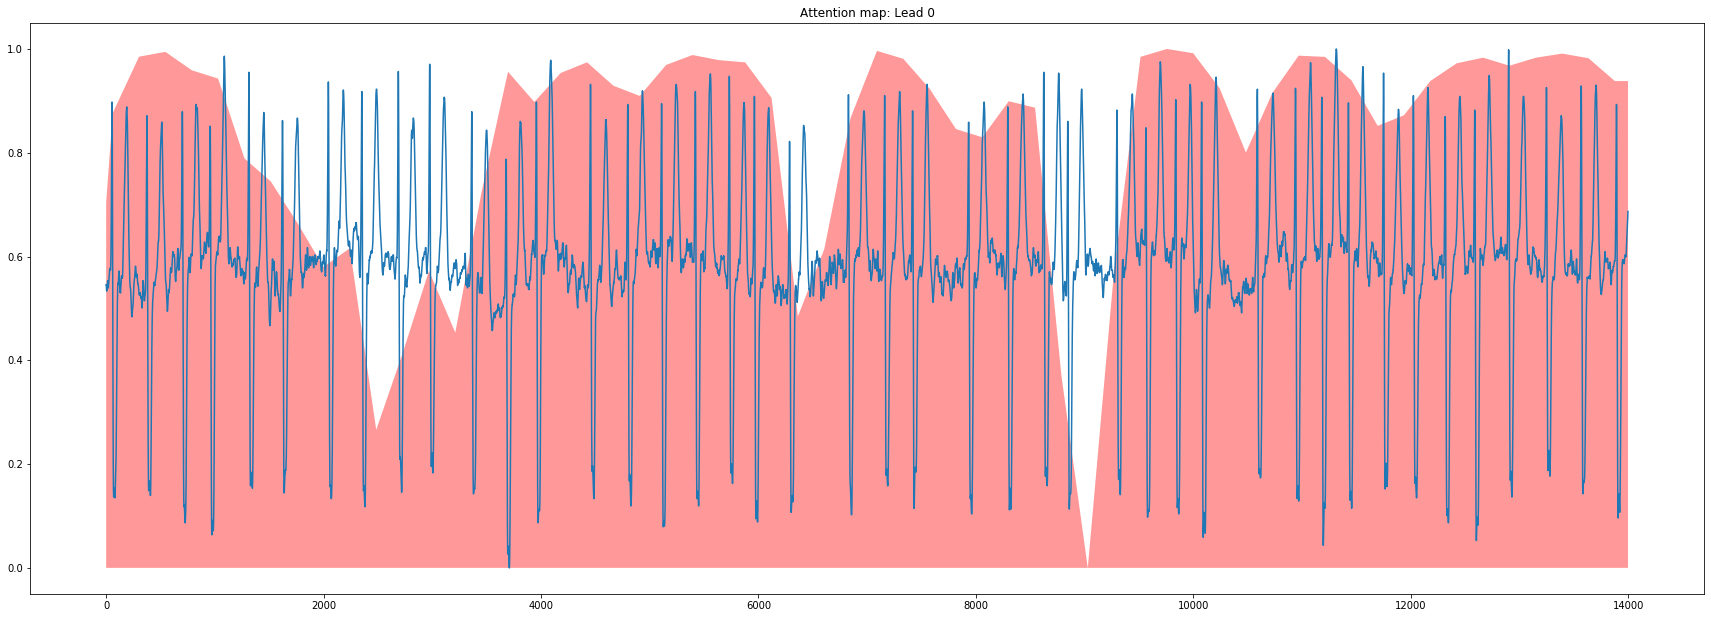

A4223.hea
[1, 0, 0, 0, 0, 0, 1, 0, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


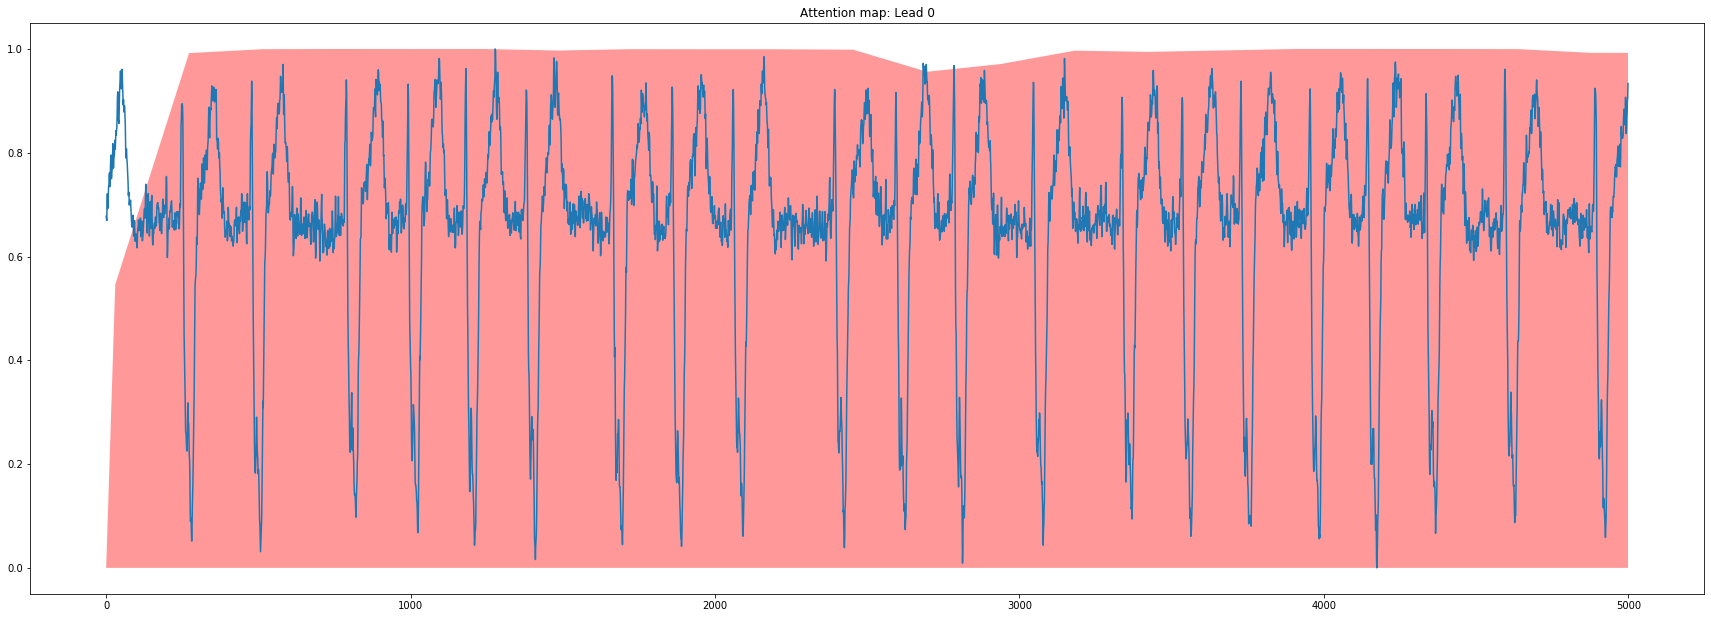

A6232.hea
[0, 0, 0, 0, 1, 0, 1, 0, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


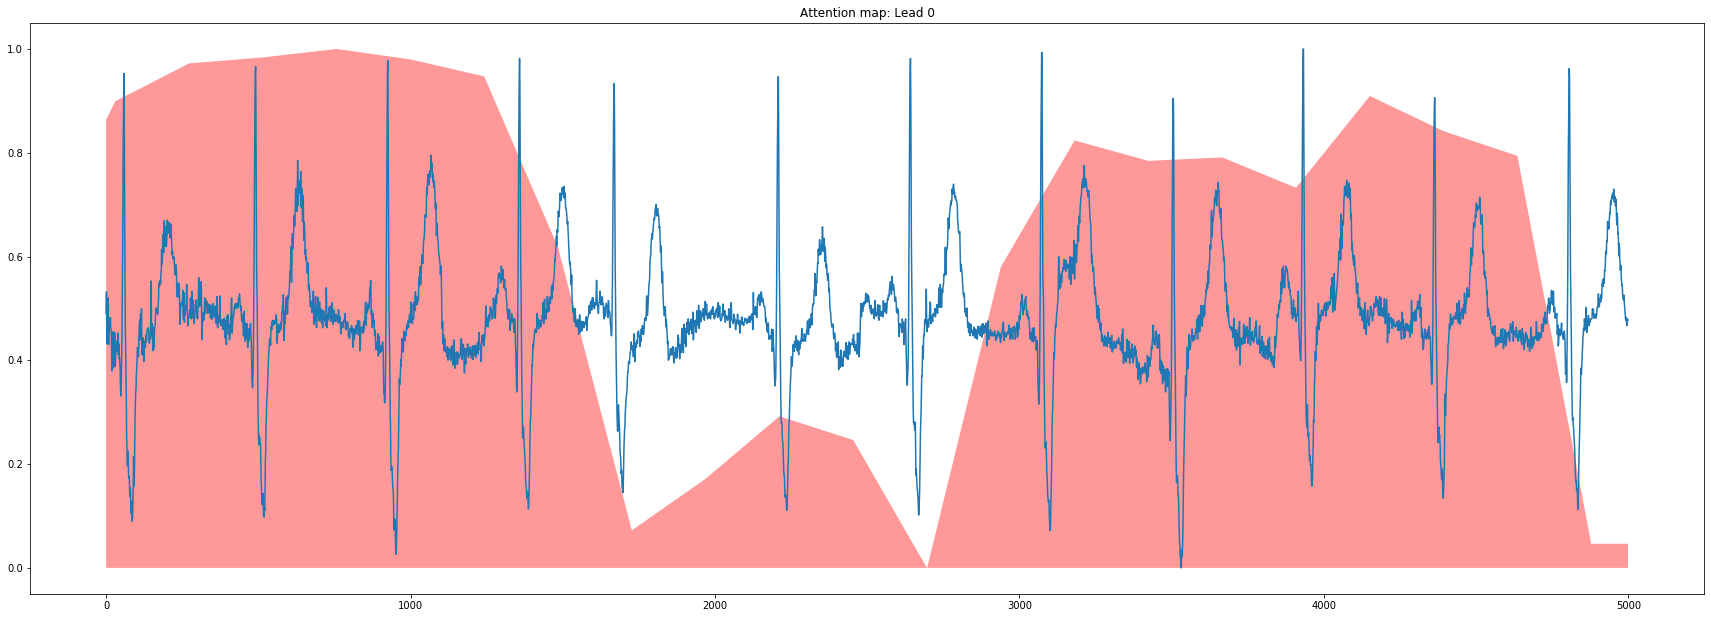

A5215.hea
[0, 0, 0, 0, 1, 0, 1, 0, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


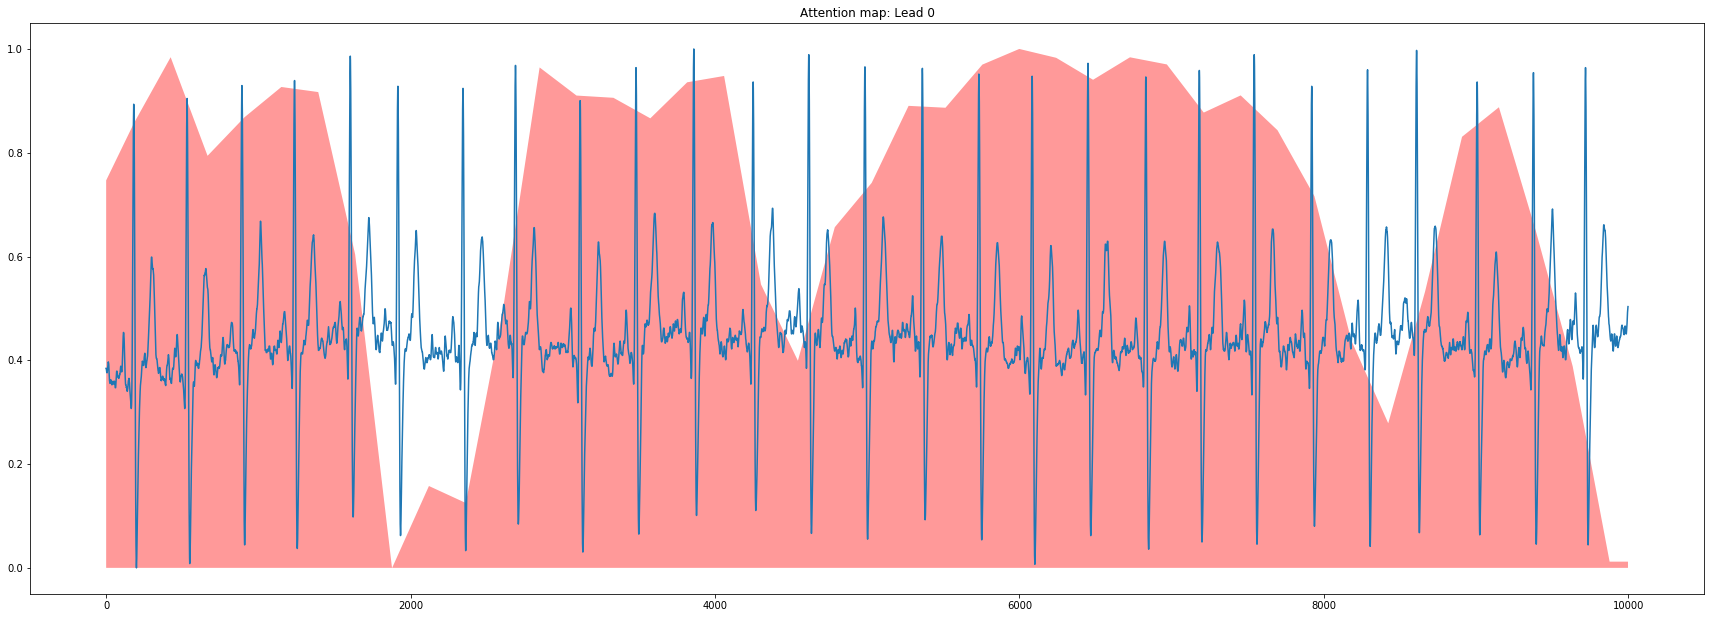

A1870.hea
[1, 0, 0, 0, 0, 0, 1, 0, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


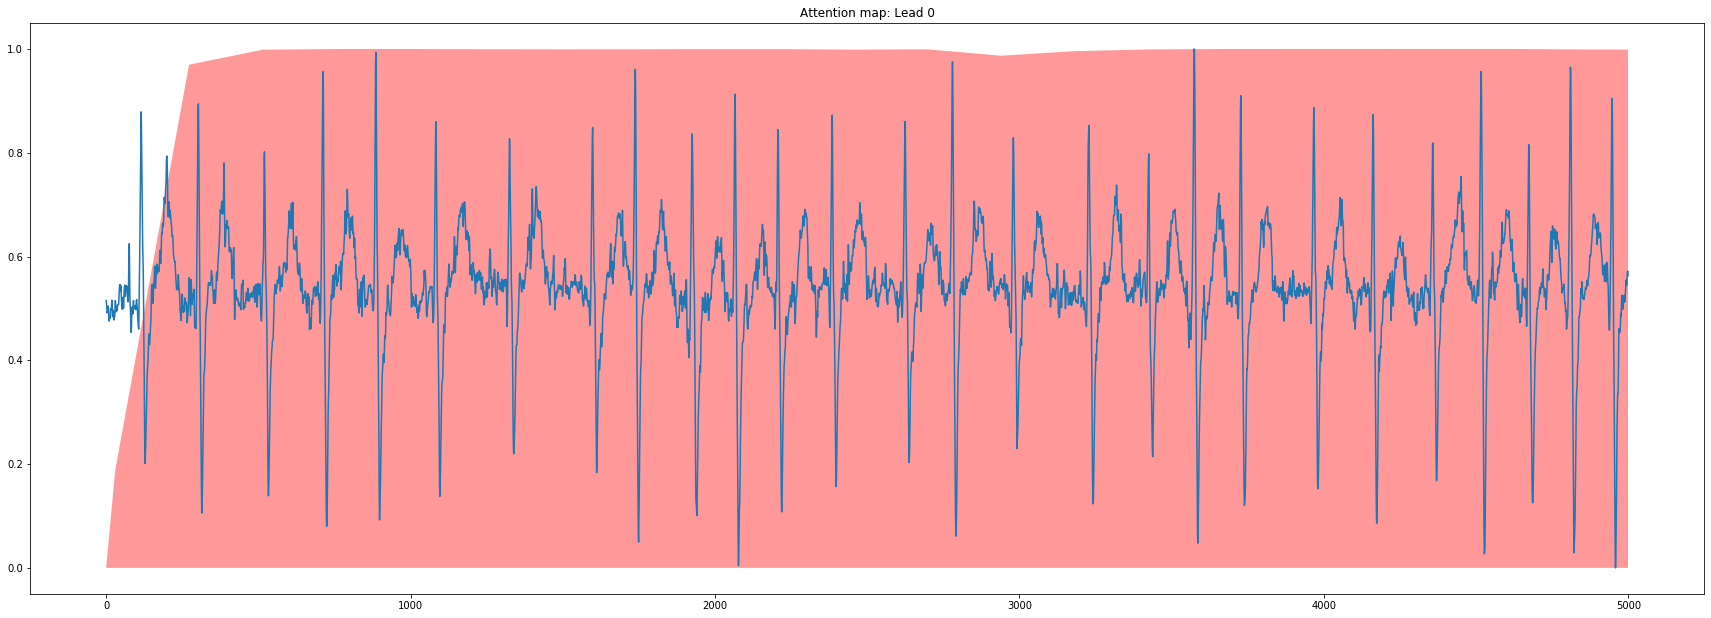

A0661.hea
[0, 0, 0, 0, 1, 0, 1, 0, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


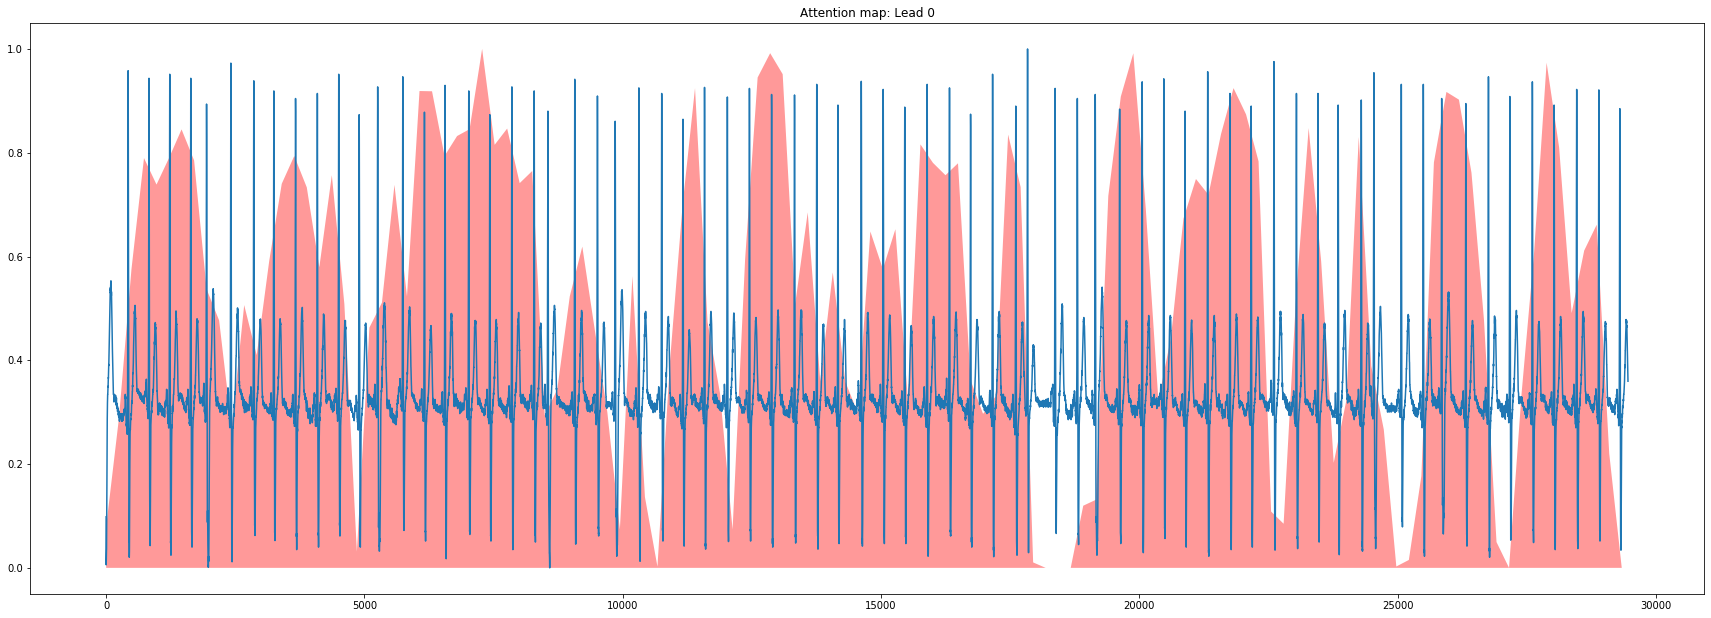

A4308.hea
[0, 0, 0, 0, 0, 1, 0, 1, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


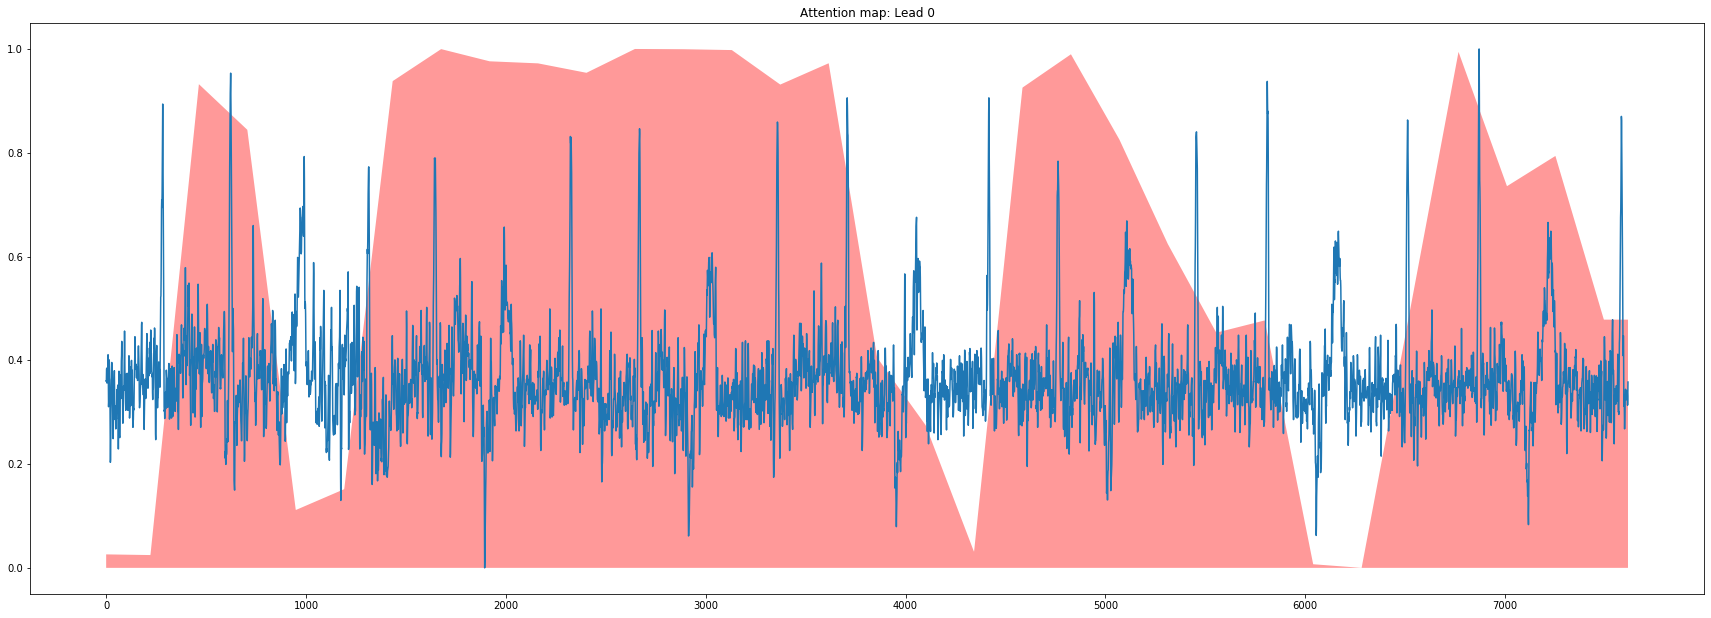

A6174.hea
[1, 0, 0, 0, 0, 0, 1, 0, 0]
{'AF': 0, 'I-AVB': 1, 'LBBB': 2, 'Normal': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}


KeyboardInterrupt: 

In [9]:
for i, mf in enumerate(multi_test):
#     mf = multi_test[88]
    tmp_file = np.load(mel_directory + '/' + mf.replace('.hea', '.npy'))

    tmp_file_ = tmp_file

    tmp_file -= x_mean_final
    tmp_file /= x_std_final
#     print(tmp_file.shape)
    zero_padding = np.zeros((minimum_len-len(tmp_file), 12))
    tmp_file = np.concatenate((zero_padding, tmp_file), axis=0)

    label = get_labels(input_directory, mf, class2index)

    preprocessed_input = np.expand_dims(tmp_file, axis=0)#np.reshape(preprocessed_input, (1,minimum_len,12))

    att_out, ideal, prediction = get_att_out(preprocessed_input)
    #     print(att_out.shape)
    # att_out2 = cv2.resize(att_out[0], (minimum_len, 1))


    att = cv2.resize(att_out[0], dsize=(1, 72000))
    trimmed = att[72000-len(tmp_file_):,0]
    
    trimmed = (trimmed - trimmed.min()) / (trimmed.max() - trimmed.min())

#     x_mean = np.mean(trimmed)
#     x_std = np.std(trimmed)

#     trimmed2 = trimmed - x_mean
#     trimmed2 = trimmed2 / x_std

#     trimmed3 = trimmed2*4
#     print(trimmed3.shape)
    print(mf)
    print(label)
    print(class2index)
    for ii in range(1):#range(12):
        plt.figure(ii, figsize=(30, 10.5))
        plt.title("Attention map: Lead " + str(ii))
        plt.fill_between(range(len(tmp_file_)), 0, trimmed, facecolor=(1,0,0,.4))
        
        curr = tmp_file_[:,ii]
        norm = (curr - curr.min()) / (curr.max() - curr.min())
        
        plt.plot(norm)
#         df = pd.DataFrame([tmp_file_[:,i], trimmed3 ])
#         df = df.transpose()
        
#         print(mf)
#         print(label)
#         print(class2index)
#         plt.figure(i,figsize=(30, 10.5))
#         plt.plot(trimmed3)
#         plt.plot(tmp_file_[:,0])
        plt.show()

### Ideal map